This serves as an easier to understand example of what the main "tractor_prep" notebook does.

## Basic Steps for Tractor preparation: 

1. Take the central 400x400 pixels of the image, sigma, and mask
2. Perform background subtractin
3. Detect all objects above the 5-sigma threshold
4. Visualize these detections using the ellipse of each object (see above)
5. Plot the half-lenght of major axis in unit of arcsec (a_arcsec) and the axis ratio of the ellipse (b_arcsec / a_arcsec); Select the a_arcsec < 0.35 and (b_arcsec / a_arcsec) > 0.9 objects as point sources.
6. Create a astropy.table for each object, save the 'x, y, x2, y2, xy, a, b, theta, flux' inforamtion.
7. Add a boolean column to indicate which object is point source.
8. Save the table into a FITS catalog.

In [1]:
import numpy as np
import os
import os.path

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep

from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

In [2]:
#step 1
num = '126'
path = 'hsc_images/'+num+'/'

img_data = fits.open(path+'redadd_'+num+'_HSC-I_full_img.fits')[0].data[400:800,400:800]
sig_data = fits.open(path+'redadd_'+num+'_HSC-I_full_sig.fits')[0].data[400:800,400:800]
msk_data = fits.open(path+'redadd_'+num+'_HSC-I_full_bad.fits')[0].data[400:800,400:800]

In [3]:
# Change the byteorder (translate the bytes)
img_data = img_data.byteswap().newbyteorder()
sig_data = sig_data.byteswap().newbyteorder()
msk_data = msk_data.byteswap().newbyteorder()

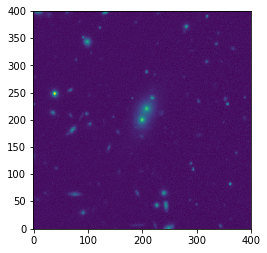

In [4]:
#step 2
bkg_model = sep.Background(img_data, mask=msk_data, bw=32, bh=32, fw=3, fh=3)
img_sub = img_data - bkg_model.back()

plt.imshow(np.arcsinh(img_sub),interpolation='none', origin='lower')

# Detect 74 objects


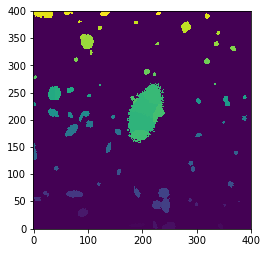

In [5]:
#step 3
obj_table, seg_data = sep.extract(img_sub, 5.0, err=sig_data, mask=msk_data, 
                                  minarea=5, deblend_nthresh=32, deblend_cont=0.001,
                                  clean=True, segmentation_map=True)

print("# Detect %d objects" % len(obj_table))
plt.imshow(seg_data, interpolation='none', origin='lower')

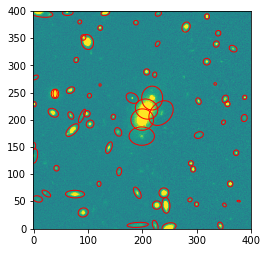

In [6]:
#step 4
#gets elliptical approximations of the ends of the galaxies

fig, ax = plt.subplots()
img_avg, img_std = np.mean(img_sub), np.std(img_sub)

im = ax.imshow(img_sub, interpolation='nearest',
               vmin=(img_avg - img_std), vmax=(img_avg + img_std), 
               origin='lower')

for i in range(len(obj_table)):
    e = Ellipse(xy=(obj_table['x'][i], 
                    obj_table['y'][i]),
                width=(6 * obj_table['a'][i]),
                height=(6 * obj_table['b'][i]),
                angle=(obj_table['theta'][i] * 180. / np.pi))
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [7]:
#step 5

#get world coordinate system from header and scale pixels to WCS
img_wcs = WCS(path+'redadd_'+num+'_HSC-I_full_img.fits') 
pixel_scale = np.abs(img_wcs.pixel_scale_matrix[0][0] * 3600.0) 

#get the arcsec length of major/minor axes
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b']) 

'The points in the top left corner are considered point sources (stars).'

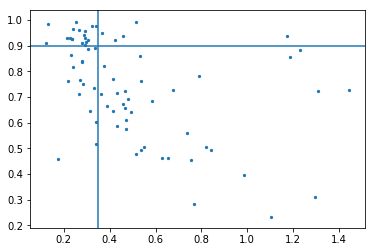

In [8]:
# Plot the size v.s. shape 
plt.scatter(a_arcsec, (b_arcsec / a_arcsec), s=5)

#plot the limits 
plt.axhline(0.9)
plt.axvline(0.35)

"""The points in the top left corner are considered point sources (stars)."""

In [9]:
#step 6

from astropy.table import Table

x = obj_table['x']
y = obj_table['y']
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a']
b = obj_table['b']
theta = obj_table['theta']
flux = obj_table['flux']

point_source = [((b_arcsec[i]/ a_arcsec[i] > .9) and (a_arcsec[i]<.35)) for i in range(len(obj_table))]

t = Table([x,y,x2,y2,xy,a,b,theta,flux,point_source], names=('x', 'y', 'x2','y2','xy','a','b','theta','flux','point_source'), meta={'name': 'object table'})

In [10]:
#step 7
tbhdu = fits.BinTableHDU.from_columns(
     [fits.Column(name='x', format='D', array=np.array(x)),
      fits.Column(name='y', format='D', array=np.array(y)),
      fits.Column(name='x2', format = 'D', array=np.array(x2)),
      fits.Column(name='y2', format = 'D', array=np.array(y2)),
      fits.Column(name='xy', format = 'D', array=np.array(xy)),
      fits.Column(name='a', format = 'D', array=np.array(a)),
      fits.Column(name='b', format = 'D', array=np.array(b)),
      fits.Column(name='theta', format = 'D', array=np.array(theta)),
      fits.Column(name='flux', format = 'D', array=np.array(flux)),
      fits.Column(name='point_source', format = 'D', array=np.array(point_source))])
tbhdu.writeto('tractor_840.fits')